In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.init as init

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple, Optional
import imageio
import dlib
from tqdm import tqdm
import warnings
import cv2
import time
import random

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-dark-palette') # Use a compatible style
plt.rcParams["figure.figsize"] = (9, 5)

In [2]:
# --- Configuration ---
SEED = 6543
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


In [4]:
FRAME_COUNT = 75
FRAME_HEIGHT = 50
FRAME_WIDTH = 100
FRAME_CHANNELS = 3
DROPOUT_P = 0.5

BASE_PROCESSED_PATH = './GRIDCorpus/processed_mouth_data/'
BASE_ALIGN_PATH = './GRIDCorpus/data/'

# ALL_SPEAKER_IDS = [f's{i}' for i in range(1, 2) if i != 21]
ALL_SPEAKER_IDS = ["s23_processed", "s24_processed", "s25_processed"]

In [5]:
# TEST_SPEAKERS_UNSEEN = ['s1', 's2', 's20', 's22']
NUM_TEST_SENTENCES_OVERLAPPED = 200 
SPLIT_MODE = 'overlapped' # Choose 'unseen' or 'overlapped'

# Normalization constants
NORM_MEAN = np.array([0.7136, 0.4906, 0.3283], dtype=np.float32)
NORM_STD = np.array([0.1138, 0.1078, 0.0917], dtype=np.float32)

In [6]:
# --- Vocabulary ---
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz "]
char_to_num_dict = {char: i + 1 for i, char in enumerate(vocab)} # Start indices from 1
num_to_char_dict = {i + 1: char for i, char in enumerate(vocab)}
VOCAB_SIZE = len(vocab)
CTC_BLANK_INDEX = 0 # CTC blank is often index 0 by convention in PyTorch
LABEL_PADDING_VALUE = CTC_BLANK_INDEX

print(
    f"The vocabulary is: {vocab} "
    f"(size ={VOCAB_SIZE})"
)
print(f"CTC Blank Index: {CTC_BLANK_INDEX}")
print(f"Label Padding Value: {LABEL_PADDING_VALUE}")

The vocabulary is: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' '] (size =27)
CTC Blank Index: 0
Label Padding Value: 0


In [9]:
def load_alignments(align_file: str) -> Optional[List[str]]:
    alignments_chars = []
    try:
        with open(align_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 3:
                    continue
                _, _, token = parts
                if token != 'sil':
                    token_characters = list(token.lower() + ' ')
                    alignments_chars.extend(token_characters)
        return alignments_chars[:-1] if alignments_chars else []
    except FileNotFoundError:
         print(f"Warning: Alignment file not found: {align_file}")
         return None
    except Exception as e:
        print(f"Error loading alignments {align_file}: {e}")
        return None

In [10]:
example_alignment = load_alignments("./GRIDCorpus/data/s1_processed/align/lrwz4p.align")
print(example_alignment)

['l', 'a', 'y', ' ', 'r', 'e', 'd', ' ', 'w', 'i', 't', 'h', ' ', 'z', ' ', 'f', 'o', 'u', 'r', ' ', 'p', 'l', 'e', 'a', 's', 'e']


In [11]:
# --- File Listing and Splitting ---
all_npy_files = []
for speaker_id in ALL_SPEAKER_IDS:
    speaker_path = os.path.join(BASE_PROCESSED_PATH, speaker_id, '*.npy')
    files = glob.glob(speaker_path)
    if not files:
        print(f"Warning: No .npy files found for speaker {speaker_id} in {os.path.join(BASE_PROCESSED_PATH, speaker_id)}")
    all_npy_files.extend(files)

if not all_npy_files:
    raise FileNotFoundError(f"No .npy files found in {BASE_PROCESSED_PATH} for speakers {ALL_SPEAKER_IDS}. Did preprocessing run?")

np.random.shuffle(all_npy_files)
train_files, test_files = [], []

if SPLIT_MODE == 'unseen':
    print(f"Using unseen speakers split. Test speakers: {TEST_SPEAKERS_UNSEEN}")
    for f in all_npy_files:
        speaker_id = os.path.basename(os.path.dirname(f))
        if speaker_id in TEST_SPEAKERS_UNSEEN:
            test_files.append(f)
        else:
            train_files.append(f)
elif SPLIT_MODE == 'overlapped':
    print(f"Using overlapped speakers split. {NUM_TEST_SENTENCES_OVERLAPPED} test sentences per speaker.")
    files_by_speaker = {}
    for f in all_npy_files:
        speaker_id = os.path.basename(os.path.dirname(f))
        if speaker_id not in files_by_speaker:
            files_by_speaker[speaker_id] = []
        files_by_speaker[speaker_id].append(f)

    for speaker_id, files in files_by_speaker.items():
        np.random.shuffle(files)
        test_count = min(NUM_TEST_SENTENCES_OVERLAPPED, len(files))
        test_files.extend(files[:test_count])
        train_files.extend(files[test_count:])
else:
    raise ValueError("Invalid SPLIT_MODE. Choose 'unseen' or 'overlapped'.")

print(f"Total files found: {len(all_npy_files)}")
print(f"Training files: {len(train_files)}")
print(f"Test files: {len(test_files)}")

if not train_files or not test_files:
    raise ValueError("Training or test set is empty. Check file paths and splitting logic.")

Using overlapped speakers split. 200 test sentences per speaker.
Total files found: 3000
Training files: 2400
Test files: 600


In [12]:
class GRIDDataset(Dataset):
    def __init__(self, file_paths: List[str], augment: bool = True):
        self.file_paths = file_paths
        self.augment = augment
        self.target_frame_count = FRAME_COUNT # Define target length

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        npy_path = self.file_paths[idx]
        try:
            frames_uint8 = np.load(npy_path)

            if frames_uint8.ndim != 4 or frames_uint8.shape[1:] != (FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS):
                 print(f"Warning: Unexpected shape {frames_uint8.shape} for {npy_path}. Skipping.")
                 return torch.zeros((FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS), dtype=torch.float32), \
                        torch.tensor([], dtype=torch.long)

            current_frame_count = frames_uint8.shape[0]
            if current_frame_count != self.target_frame_count:
                if current_frame_count > self.target_frame_count:
                    frames_uint8 = frames_uint8[:self.target_frame_count, ...]
                else:
                    pad_width = ((0, self.target_frame_count - current_frame_count), (0, 0), (0, 0), (0, 0))
                    frames_uint8 = np.pad(frames_uint8, pad_width, mode='constant', constant_values=0)

            frames_float = frames_uint8.astype(np.float32) / 255.0
            frames_rgb = frames_float[..., ::-1] # BGR to RGB
            frames_normalized = (frames_rgb - NORM_MEAN) / NORM_STD
            frames_tensor = torch.tensor(frames_normalized, dtype=torch.float32)
            # Shape should now be guaranteed [75, 50, 100, 3]

            # getting alignments
            parts = npy_path.split(os.path.sep)
            speaker_id = parts[-2]
            base_name = os.path.splitext(parts[-1])[0]
            if base_name.endswith('_mouth'):
                base_name = base_name[:-6]
            align_file = os.path.join(BASE_ALIGN_PATH, speaker_id, "align", f'{base_name}.align')
            alignments_list = load_alignments(align_file)

            if alignments_list is None:
                print(f"Skipping {npy_path} due to missing alignment.")
                return torch.zeros((FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS), dtype=torch.float32), \
                       torch.tensor([], dtype=torch.long)

            label_indices = [char_to_num_dict.get(char, CTC_BLANK_INDEX) for char in alignments_list] # Use blank for OOV
            label_tensor = torch.tensor(label_indices, dtype=torch.long)

            if self.augment and torch.rand(1).item() > 0.5:
                frames_tensor = torch.flip(frames_tensor, dims=[2]) # Flip width dimension

            return frames_tensor, label_tensor

        except FileNotFoundError:
            print(f"Warning: File not found {npy_path}. Skipping.")
            return torch.zeros((FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS), dtype=torch.float32), \
                   torch.tensor([], dtype=torch.long)
        except Exception as e:
            print(f"Error loading item {idx} ({npy_path}): {e}")
            return torch.zeros((FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS), dtype=torch.float32), \
                   torch.tensor([], dtype=torch.long)

In [13]:
def collate_fn(batch):
    batch = [(frames, labels) for frames, labels in batch if labels.numel() > 0]
    if not batch:
        return torch.tensor([]), torch.tensor([]), torch.tensor([]), torch.tensor([])
    frames_list, labels_list = zip(*batch)
    frames_batch = torch.stack(frames_list, dim=0)
    label_lengths = torch.tensor([len(lbl) for lbl in labels_list], dtype=torch.long)
    labels_padded = pad_sequence(labels_list, batch_first=True, padding_value=LABEL_PADDING_VALUE)
    input_lengths = torch.full(size=(len(batch),), fill_value=FRAME_COUNT, dtype=torch.long)
    return frames_batch, labels_padded, input_lengths, label_lengths

In [1]:
# --- Data Loaders ---
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32

train_dataset = GRIDDataset(train_files, augment=True)
test_dataset = GRIDDataset(test_files, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True,
                          collate_fn=collate_fn, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False,
                         collate_fn=collate_fn, num_workers=4, pin_memory=True)

print("DataLoaders created.")
# Test one batch
try:
    d_frames, d_labels, d_in_len, d_lbl_len = next(iter(train_loader))
    print("Train Batch Shapes:", d_frames.shape, d_labels.shape, d_in_len.shape, d_lbl_len.shape)
    d_frames, d_labels, d_in_len, d_lbl_len = next(iter(test_loader))
    print("Test Batch Shapes:", d_frames.shape, d_labels.shape, d_in_len.shape, d_lbl_len.shape)
except Exception as e:
     print(f"Error fetching batch: {e}")


NameError: name 'GRIDDataset' is not defined

In [15]:
# --- PyTorch LipNet Model ---
class LipNet(nn.Module):
    def __init__(self, num_classes, dropout_p=DROPOUT_P):
        super(LipNet, self).__init__()
        self.num_classes = num_classes # Should include blank token
        self.dropout_p = dropout_p

        # Spatiotemporal Convolutional Layers (STCNN)
        self.conv1 = nn.Conv3d(FRAME_CHANNELS, 32, kernel_size=(3, 5, 5), stride=(1, 2, 2), padding=(1, 2, 2))
        self.bn1 = nn.BatchNorm3d(32)
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.drop1 = nn.Dropout3d(dropout_p)

        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 5, 5), stride=(1, 1, 1), padding=(1, 2, 2))
        self.bn2 = nn.BatchNorm3d(64)
        self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.drop2 = nn.Dropout3d(dropout_p)

        self.conv3 = nn.Conv3d(64, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.bn3 = nn.BatchNorm3d(96)
        self.pool3 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.drop3 = nn.Dropout3d(dropout_p)
        self.rnn_input_size = 96 * 3 * 6 # C_out * H_out * W_out

        # Bidirectional GRU Layers
        self.gru1 = nn.GRU(self.rnn_input_size, 256, bidirectional=True, batch_first=True)
        self.drop_gru1 = nn.Dropout(dropout_p)
        self.gru2 = nn.GRU(256 * 2, 256, bidirectional=True, batch_first=True) # Input size is doubled from previous BiGRU
        self.drop_gru2 = nn.Dropout(dropout_p)

        # Fully Connected Layer
        self.fc = nn.Linear(256 * 2, self.num_classes)

        #Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.GRU):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name: # Input-hidden weights
                        init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name: # Hidden-hidden weights
                        init.orthogonal_(param.data)
                    elif 'bias' in name: # Biases
                        init.constant_(param.data, 0)
            elif isinstance(m, nn.Linear):
                 init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') # He for Dense
                 if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = x.permute(0, 4, 1, 2, 3).contiguous()

        # STCNN blocks
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.drop2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.drop3(x)

        N, C, T, H, W = x.size()
        x = x.permute(0, 2, 1, 3, 4).contiguous() # (N, T, C, H, W)
        x = x.view(N, T, -1) # Flatten C, H, W dims

        # Bi-GRU layers
        x, _ = self.gru1(x)
        x = self.drop_gru1(x)
        x, _ = self.gru2(x)
        x = self.drop_gru2(x)

        # Fully Connected Layer
        x = self.fc(x) # Output shape: (N, T, num_classes)

        # Prepare for CTC Loss: (T, N, C) and apply log_softmax
        x = x.permute(1, 0, 2).contiguous() # T, N, C
        log_probs = F.log_softmax(x, dim=2)

        return log_probs

In [16]:
model = LipNet(num_classes=VOCAB_SIZE + 1).to(DEVICE) # +1 for blank

try:
    from torchinfo import summary
    print(summary(model, input_size=(BATCH_SIZE_TRAIN, FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS)))
except ImportError:
    print("torchinfo not installed. Skipping model summary.")
    print(model)

Layer (type:depth-idx)                   Output Shape              Param #
LipNet                                   [75, 32, 28]              --
├─Conv3d: 1-1                            [32, 32, 75, 25, 50]      7,232
├─BatchNorm3d: 1-2                       [32, 32, 75, 25, 50]      64
├─MaxPool3d: 1-3                         [32, 32, 75, 12, 25]      --
├─Dropout3d: 1-4                         [32, 32, 75, 12, 25]      --
├─Conv3d: 1-5                            [32, 64, 75, 12, 25]      153,664
├─BatchNorm3d: 1-6                       [32, 64, 75, 12, 25]      128
├─MaxPool3d: 1-7                         [32, 64, 75, 6, 12]       --
├─Dropout3d: 1-8                         [32, 64, 75, 6, 12]       --
├─Conv3d: 1-9                            [32, 96, 75, 6, 12]       165,984
├─BatchNorm3d: 1-10                      [32, 96, 75, 6, 12]       192
├─MaxPool3d: 1-11                        [32, 96, 75, 3, 6]        --
├─Dropout3d: 1-12                        [32, 96, 75, 3, 6]        --


In [17]:
# --- Loss Function ---
ctc_loss = nn.CTCLoss(blank=CTC_BLANK_INDEX, reduction='mean', zero_infinity=True)

# --- Optimizer ---
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay = 1e-4)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True)

In [18]:
# --- Checkpoint Path ---
checkpoint_dir = 'models_pytorch'
checkpoint_path = os.path.join(checkpoint_dir, 'lipnet_checkpoint.pth')
os.makedirs(checkpoint_dir, exist_ok=True)

In [19]:
def greedy_decoder(log_probs, input_lengths):
    decoded_sequences = []
    for i in range(log_probs.size(1)): 
        sample_log_probs = log_probs[:input_lengths[i], i, :]
        best_path = torch.argmax(sample_log_probs, dim=1)
        decoded = []
        last_char = -1
        for char_idx in best_path:
            idx = char_idx.item()
            if idx != last_char and idx != CTC_BLANK_INDEX:
                decoded.append(idx)
            if idx != CTC_BLANK_INDEX: 
                last_char = idx
        decoded_sequences.append(decoded)
    return decoded_sequences
def produce_example(model, dataset_loader, num_to_char_map):
    model.eval() 
    with torch.no_grad():
        try:
            frames_batch, labels_batch, input_lengths, label_lengths = next(iter(dataset_loader))
            frames_batch = frames_batch.to(DEVICE)
            log_probs = model(frames_batch) 
            log_probs_cpu = log_probs.cpu()
            raw_argmax = torch.argmax(log_probs_cpu[:, 0, :], dim=1) 
            print(f"Raw Argmax Indices (Example 1): {raw_argmax.tolist()}")
            input_lengths_cpu = input_lengths.cpu()
            decoded_indices_list = greedy_decoder(log_probs_cpu, input_lengths_cpu)
            print("\n--- Example Predictions ---")
            N_EXAMPLES_TO_SHOW = min(2, frames_batch.size(0))
            for i in range(N_EXAMPLES_TO_SHOW):
                original_indices = labels_batch[i][:label_lengths[i]].tolist()
                original_text = "".join([num_to_char_map.get(idx, '?') for idx in original_indices])
                print(f'Original:     {original_text}')
                prediction_indices = decoded_indices_list[i]
                print(f'Filtered Idx: {prediction_indices}') 
                prediction_text = "".join([num_to_char_map.get(idx, '?') for idx in prediction_indices])
                print(f'Prediction:   {prediction_text}')
                print('-'*50)
            print("--- End Examples ---\n")
        except StopIteration:
            print("Warning: Could not get a batch from the dataset loader for ProduceExample.")
        except Exception as e:
            print(f"Error during ProduceExample: {e}")
    model.train()

In [20]:
# --- Training Loop ---
EPOCHS = 300
best_val_loss = float('inf')
train_losses = []
val_losses = []

# Load checkpoint if exists
start_epoch = 0
if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}")
    try:
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['loss']
        print(f"Resuming training from epoch {start_epoch}, Best loss: {best_val_loss:.4f}")
    except Exception as e:
        print(f"Error loading checkpoint: {e}. Starting from scratch.")
        start_epoch = 0
        best_val_loss = float('inf')


print("\nStarting Training...")
num_train_batches = len(train_loader)
num_test_batches = len(test_loader)
print(f"Training batches per epoch: {num_train_batches}")
print(f"Validation batches per epoch: {num_test_batches}")


for epoch in range(start_epoch, EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    model.train()
    running_loss = 0.0
    train_pbar = tqdm(enumerate(train_loader), total=num_train_batches, desc=f"Epoch {epoch+1} Train")

    for i, batch_data in train_pbar:
        frames_batch, labels_padded, input_lengths, label_lengths = batch_data

        # Move data to device
        frames_batch = frames_batch.to(DEVICE)
        labels_padded = labels_padded.to(DEVICE)
        input_lengths = input_lengths.to(DEVICE)
        label_lengths = label_lengths.to(DEVICE)

        optimizer.zero_grad()

        log_probs = model(frames_batch)

        T = log_probs.size(0)
        input_lengths = torch.clamp(input_lengths, max=T)

        loss = ctc_loss(log_probs, labels_padded.cpu(), input_lengths.cpu(), label_lengths.cpu())

        # Check for NaN/inf loss
        if torch.isnan(loss) or torch.isinf(loss):
             print(f"Warning: NaN or Inf loss detected at batch {i}. Skipping batch.")
             continue # Skip gradient update for this batch

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Clip gradients
        optimizer.step()
        
        running_loss += loss.item()
        train_pbar.set_postfix({'loss': running_loss / (i + 1)})

    avg_train_loss = running_loss / num_train_batches
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.4f}")

    # --- Validation ---
    model.eval()
    running_val_loss = 0.0
    val_pbar = tqdm(enumerate(test_loader), total=num_test_batches, desc=f"Epoch {epoch+1} Val")
    with torch.no_grad():
        for i, batch_data in val_pbar:
            frames_batch, labels_padded, input_lengths, label_lengths = batch_data
            frames_batch = frames_batch.to(DEVICE)
            labels_padded = labels_padded.to(DEVICE)
            input_lengths = input_lengths.to(DEVICE)
            label_lengths = label_lengths.to(DEVICE)

            log_probs = model(frames_batch)
            T = log_probs.size(0)
            input_lengths = torch.clamp(input_lengths, max=T)

            loss = ctc_loss(log_probs, labels_padded.cpu(), input_lengths.cpu(), label_lengths.cpu())

            if not (torch.isnan(loss) or torch.isinf(loss)):
                running_val_loss += loss.item()
            val_pbar.set_postfix({'val_loss': running_val_loss / (i + 1)})

    avg_val_loss = running_val_loss / num_test_batches
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")
    scheduler.step(avg_val_loss)

    # --- Save Checkpoint ---
    if avg_val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}, saving model to {checkpoint_path}")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }, checkpoint_path)
        best_val_loss = avg_val_loss
    else:
        print(f"Validation loss ({avg_val_loss:.4f}) did not improve from {best_val_loss:.4f}")

    # --- Show Examples (e.g., every 5 epochs) ---
    if (epoch + 1) % 5 == 0 or epoch == EPOCHS - 1:
         produce_example(model, test_loader, num_to_char_dict)

print("\nTraining Finished.")

Loading checkpoint from models_pytorch/lipnet_checkpoint.pth
Resuming training from epoch 200, Best loss: 1.6684

Starting Training...
Training batches per epoch: 75
Validation batches per epoch: 19

Epoch 201/300


Epoch 201 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.77]

Epoch 201 Training Loss: 1.7676



Epoch 201 Val: 100%|██████████| 19/19 [00:04<00:00,  3.99it/s, val_loss=1.68]

Epoch 201 Validation Loss: 1.6841
Validation loss (1.6841) did not improve from 1.6684

Epoch 202/300



Epoch 202 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.77]

Epoch 202 Training Loss: 1.7685



Epoch 202 Val: 100%|██████████| 19/19 [00:04<00:00,  3.93it/s, val_loss=1.69]

Epoch 202 Validation Loss: 1.6896
Validation loss (1.6896) did not improve from 1.6684

Epoch 203/300



Epoch 203 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.76]

Epoch 203 Training Loss: 1.7643



Epoch 203 Val: 100%|██████████| 19/19 [00:04<00:00,  3.94it/s, val_loss=1.67]

Epoch 203 Validation Loss: 1.6727
Validation loss (1.6727) did not improve from 1.6684

Epoch 204/300



Epoch 204 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.76]

Epoch 204 Training Loss: 1.7617



Epoch 204 Val: 100%|██████████| 19/19 [00:04<00:00,  4.00it/s, val_loss=1.68]

Epoch 204 Validation Loss: 1.6799
Validation loss (1.6799) did not improve from 1.6684

Epoch 205/300



Epoch 205 Train: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s, loss=1.76]

Epoch 205 Training Loss: 1.7607



Epoch 205 Val: 100%|██████████| 19/19 [00:04<00:00,  3.89it/s, val_loss=1.67]

Epoch 205 Validation Loss: 1.6739
Validation loss (1.6739) did not improve from 1.6684


Raw Argmax Indices (Example 1): [19, 0, 1, 20, 27, 27, 23, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 20, 27, 27, 27, 27, 27, 27, 27, 27, 27, 9, 9, 5, 0, 0, 27, 27, 0, 0, 0, 1, 15, 14]

--- Example Predictions ---
Original:     set blue with f four now
Filtered Idx: [19, 1, 20, 27, 23, 18, 5, 9, 20, 27, 9, 5, 27, 1, 15, 14]
Prediction:   sat wreit ie aon
--------------------------------------------------
Original:     set white in m one again
Filtered Idx: [19, 1, 25, 27, 23, 18, 9, 20, 27, 9, 5, 27, 15, 14]
Prediction:   say writ ie on
--------------------------------------------------
--- End Examples ---


Epoch 206/300


Epoch 206 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.76]

Epoch 206 Training Loss: 1.7613



Epoch 206 Val: 100%|██████████| 19/19 [00:04<00:00,  4.07it/s, val_loss=1.67]

Epoch 206 Validation Loss: 1.6747
Validation loss (1.6747) did not improve from 1.6684

Epoch 207/300



Epoch 207 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.75]

Epoch 207 Training Loss: 1.7543



Epoch 207 Val: 100%|██████████| 19/19 [00:04<00:00,  4.07it/s, val_loss=1.66]


Epoch 207 Validation Loss: 1.6604
Validation loss improved from 1.6684 to 1.6604, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 208/300


Epoch 208 Train: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s, loss=1.76]

Epoch 208 Training Loss: 1.7570



Epoch 208 Val: 100%|██████████| 19/19 [00:04<00:00,  4.05it/s, val_loss=1.66]

Epoch 208 Validation Loss: 1.6633
Validation loss (1.6633) did not improve from 1.6604

Epoch 209/300



Epoch 209 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.76]

Epoch 209 Training Loss: 1.7556



Epoch 209 Val: 100%|██████████| 19/19 [00:04<00:00,  4.04it/s, val_loss=1.67]

Epoch 209 Validation Loss: 1.6673
Validation loss (1.6673) did not improve from 1.6604

Epoch 210/300



Epoch 210 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.76]

Epoch 210 Training Loss: 1.7552



Epoch 210 Val: 100%|██████████| 19/19 [00:04<00:00,  4.04it/s, val_loss=1.63]


Epoch 210 Validation Loss: 1.6341
Validation loss improved from 1.6604 to 1.6341, saving model to models_pytorch/lipnet_checkpoint.pth
Raw Argmax Indices (Example 1): [19, 0, 1, 25, 27, 27, 23, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 20, 27, 27, 27, 27, 27, 27, 27, 27, 27, 9, 9, 5, 0, 0, 27, 27, 0, 0, 0, 0, 15, 14]

--- Example Predictions ---
Original:     set blue with f four now
Filtered Idx: [19, 1, 25, 27, 23, 18, 5, 9, 20, 27, 9, 5, 27, 15, 14]
Prediction:   say wreit ie on
--------------------------------------------------
Original:     set white in m one again
Filtered Idx: [19, 1, 25, 27, 23, 18, 5, 9, 20, 27, 9, 5, 27, 1, 15, 14]
Prediction:   say wreit ie aon
--------------------------------------------------
--- End Examples ---


Epoch 211/300


Epoch 211 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.75]

Epoch 211 Training Loss: 1.7481



Epoch 211 Val: 100%|██████████| 19/19 [00:04<00:00,  3.98it/s, val_loss=1.67]

Epoch 211 Validation Loss: 1.6747
Validation loss (1.6747) did not improve from 1.6341

Epoch 212/300



Epoch 212 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.75]

Epoch 212 Training Loss: 1.7473



Epoch 212 Val: 100%|██████████| 19/19 [00:04<00:00,  3.85it/s, val_loss=1.65]

Epoch 212 Validation Loss: 1.6511
Validation loss (1.6511) did not improve from 1.6341

Epoch 213/300



Epoch 213 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.75]

Epoch 213 Training Loss: 1.7451



Epoch 213 Val: 100%|██████████| 19/19 [00:05<00:00,  3.78it/s, val_loss=1.64]

Epoch 213 Validation Loss: 1.6431
Validation loss (1.6431) did not improve from 1.6341

Epoch 214/300



Epoch 214 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.75]

Epoch 214 Training Loss: 1.7461



Epoch 214 Val: 100%|██████████| 19/19 [00:04<00:00,  3.96it/s, val_loss=1.64]

Epoch 214 Validation Loss: 1.6366
Validation loss (1.6366) did not improve from 1.6341

Epoch 215/300



Epoch 215 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.74]

Epoch 215 Training Loss: 1.7429



Epoch 215 Val: 100%|██████████| 19/19 [00:04<00:00,  3.95it/s, val_loss=1.65]

Epoch 215 Validation Loss: 1.6544
Validation loss (1.6544) did not improve from 1.6341


Raw Argmax Indices (Example 1): [19, 0, 1, 20, 27, 27, 23, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 20, 27, 27, 27, 27, 27, 27, 27, 27, 27, 9, 9, 5, 0, 0, 27, 27, 27, 0, 14, 1, 15, 14]

--- Example Predictions ---
Original:     set blue with f four now
Filtered Idx: [19, 1, 20, 27, 23, 18, 5, 9, 20, 27, 9, 5, 27, 14, 1, 15, 14]
Prediction:   sat wreit ie naon
--------------------------------------------------
Original:     set white in m one again
Filtered Idx: [19, 1, 20, 27, 23, 18, 9, 20, 27, 9, 5, 27, 15, 1, 15, 14]
Prediction:   sat writ ie oaon
--------------------------------------------------
--- End Examples ---


Epoch 216/300


Epoch 216 Train: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s, loss=1.74]

Epoch 216 Training Loss: 1.7414



Epoch 216 Val: 100%|██████████| 19/19 [00:04<00:00,  3.87it/s, val_loss=1.65]

Epoch 216 Validation Loss: 1.6454
Validation loss (1.6454) did not improve from 1.6341

Epoch 217/300



Epoch 217 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.74]

Epoch 217 Training Loss: 1.7384



Epoch 217 Val: 100%|██████████| 19/19 [00:05<00:00,  3.77it/s, val_loss=1.64]

Epoch 217 Validation Loss: 1.6362
Validation loss (1.6362) did not improve from 1.6341

Epoch 218/300



Epoch 218 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.74]

Epoch 218 Training Loss: 1.7382



Epoch 218 Val: 100%|██████████| 19/19 [00:04<00:00,  3.83it/s, val_loss=1.64]

Epoch 218 Validation Loss: 1.6358
Validation loss (1.6358) did not improve from 1.6341

Epoch 219/300



Epoch 219 Train: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s, loss=1.74]

Epoch 219 Training Loss: 1.7372



Epoch 219 Val: 100%|██████████| 19/19 [00:04<00:00,  3.90it/s, val_loss=1.63]


Epoch 219 Validation Loss: 1.6317
Validation loss improved from 1.6341 to 1.6317, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 220/300


Epoch 220 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.74]

Epoch 220 Training Loss: 1.7361



Epoch 220 Val: 100%|██████████| 19/19 [00:04<00:00,  4.05it/s, val_loss=1.63]


Epoch 220 Validation Loss: 1.6267
Validation loss improved from 1.6317 to 1.6267, saving model to models_pytorch/lipnet_checkpoint.pth
Raw Argmax Indices (Example 1): [19, 0, 1, 20, 27, 27, 23, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 20, 27, 27, 27, 27, 27, 27, 27, 27, 27, 19, 9, 5, 0, 0, 27, 27, 27, 0, 14, 1, 15, 14]

--- Example Predictions ---
Original:     set blue with f four now
Filtered Idx: [19, 1, 20, 27, 23, 18, 5, 9, 20, 27, 19, 9, 5, 27, 14, 1, 15, 14]
Prediction:   sat wreit sie naon
--------------------------------------------------
Original:     set white in m one again
Filtered Idx: [19, 1, 25, 27, 23, 18, 5, 9, 20, 27, 9, 5, 27, 15, 1, 15, 14]
Prediction:   say wreit ie oaon
--------------------------------------------------
--- End Examples ---


Epoch 221/300


Epoch 221 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.74]

Epoch 221 Training Loss: 1.7352



Epoch 221 Val: 100%|██████████| 19/19 [00:04<00:00,  3.84it/s, val_loss=1.63]


Epoch 221 Validation Loss: 1.6260
Validation loss improved from 1.6267 to 1.6260, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 222/300


Epoch 222 Train: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s, loss=1.73]

Epoch 222 Training Loss: 1.7327



Epoch 222 Val: 100%|██████████| 19/19 [00:04<00:00,  4.05it/s, val_loss=1.63]


Epoch 222 Validation Loss: 1.6260
Validation loss improved from 1.6260 to 1.6260, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 223/300


Epoch 223 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.73]

Epoch 223 Training Loss: 1.7311



Epoch 223 Val: 100%|██████████| 19/19 [00:04<00:00,  3.85it/s, val_loss=1.63]

Epoch 223 Validation Loss: 1.6267
Validation loss (1.6267) did not improve from 1.6260

Epoch 224/300



Epoch 224 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.73]

Epoch 224 Training Loss: 1.7342



Epoch 224 Val: 100%|██████████| 19/19 [00:04<00:00,  3.99it/s, val_loss=1.63]

Epoch 224 Validation Loss: 1.6287
Validation loss (1.6287) did not improve from 1.6260

Epoch 225/300



Epoch 225 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.73]

Epoch 225 Training Loss: 1.7348



Epoch 225 Val: 100%|██████████| 19/19 [00:04<00:00,  3.85it/s, val_loss=1.63]

Epoch 225 Validation Loss: 1.6262
Validation loss (1.6262) did not improve from 1.6260


Raw Argmax Indices (Example 1): [19, 0, 1, 20, 27, 27, 7, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 20, 27, 27, 27, 27, 27, 27, 27, 27, 27, 9, 9, 5, 0, 0, 27, 27, 27, 0, 14, 1, 15, 14]

--- Example Predictions ---
Original:     set blue with f four now
Filtered Idx: [19, 1, 20, 27, 7, 18, 5, 9, 20, 27, 9, 5, 27, 14, 1, 15, 14]
Prediction:   sat greit ie naon
--------------------------------------------------
Original:     set white in m one again
Filtered Idx: [19, 1, 25, 27, 23, 18, 5, 9, 20, 27, 9, 5, 27, 15, 1, 15, 14]
Prediction:   say wreit ie oaon
--------------------------------------------------
--- End Examples ---


Epoch 226/300


Epoch 226 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.73]

Epoch 226 Training Loss: 1.7339



Epoch 226 Val: 100%|██████████| 19/19 [00:04<00:00,  3.91it/s, val_loss=1.63]


Epoch 226 Validation Loss: 1.6252
Validation loss improved from 1.6260 to 1.6252, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 227/300


Epoch 227 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.73]

Epoch 227 Training Loss: 1.7346



Epoch 227 Val: 100%|██████████| 19/19 [00:04<00:00,  3.99it/s, val_loss=1.62]


Epoch 227 Validation Loss: 1.6246
Validation loss improved from 1.6252 to 1.6246, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 228/300


Epoch 228 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.73]

Epoch 228 Training Loss: 1.7310



Epoch 228 Val: 100%|██████████| 19/19 [00:04<00:00,  3.91it/s, val_loss=1.63]

Epoch 228 Validation Loss: 1.6278
Validation loss (1.6278) did not improve from 1.6246

Epoch 229/300



Epoch 229 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.73]

Epoch 229 Training Loss: 1.7292



Epoch 229 Val: 100%|██████████| 19/19 [00:04<00:00,  4.04it/s, val_loss=1.62]


Epoch 229 Validation Loss: 1.6218
Validation loss improved from 1.6246 to 1.6218, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 230/300


Epoch 230 Train: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s, loss=1.73]

Epoch 230 Training Loss: 1.7308



Epoch 230 Val: 100%|██████████| 19/19 [00:04<00:00,  4.00it/s, val_loss=1.62]


Epoch 230 Validation Loss: 1.6211
Validation loss improved from 1.6218 to 1.6211, saving model to models_pytorch/lipnet_checkpoint.pth
Raw Argmax Indices (Example 1): [19, 0, 1, 20, 27, 27, 7, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 20, 27, 27, 27, 27, 27, 27, 27, 27, 27, 9, 9, 5, 0, 0, 27, 27, 27, 0, 14, 1, 15, 14]

--- Example Predictions ---
Original:     set blue with f four now
Filtered Idx: [19, 1, 20, 27, 7, 18, 5, 9, 20, 27, 9, 5, 27, 14, 1, 15, 14]
Prediction:   sat greit ie naon
--------------------------------------------------
Original:     set white in m one again
Filtered Idx: [19, 1, 25, 27, 23, 18, 5, 20, 27, 9, 5, 27, 15, 1, 15, 14]
Prediction:   say wret ie oaon
--------------------------------------------------
--- End Examples ---


Epoch 231/300


Epoch 231 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.73]

Epoch 231 Training Loss: 1.7307



Epoch 231 Val: 100%|██████████| 19/19 [00:04<00:00,  4.06it/s, val_loss=1.62]

Epoch 231 Validation Loss: 1.6214
Validation loss (1.6214) did not improve from 1.6211

Epoch 232/300



Epoch 232 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.73]

Epoch 232 Training Loss: 1.7314



Epoch 232 Val: 100%|██████████| 19/19 [00:04<00:00,  3.94it/s, val_loss=1.62]


Epoch 232 Validation Loss: 1.6198
Validation loss improved from 1.6211 to 1.6198, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 233/300


Epoch 233 Train: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s, loss=1.73]

Epoch 233 Training Loss: 1.7260



Epoch 233 Val: 100%|██████████| 19/19 [00:04<00:00,  4.05it/s, val_loss=1.63]

Epoch 233 Validation Loss: 1.6277
Validation loss (1.6277) did not improve from 1.6198

Epoch 234/300



Epoch 234 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.73]

Epoch 234 Training Loss: 1.7306



Epoch 234 Val: 100%|██████████| 19/19 [00:04<00:00,  3.85it/s, val_loss=1.63]

Epoch 234 Validation Loss: 1.6276
Validation loss (1.6276) did not improve from 1.6198

Epoch 235/300



Epoch 235 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.73]

Epoch 235 Training Loss: 1.7322



Epoch 235 Val: 100%|██████████| 19/19 [00:04<00:00,  3.84it/s, val_loss=1.62]

Epoch 235 Validation Loss: 1.6206
Validation loss (1.6206) did not improve from 1.6198


Raw Argmax Indices (Example 1): [19, 0, 1, 20, 27, 27, 7, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 20, 27, 27, 27, 27, 27, 27, 27, 27, 27, 19, 9, 5, 0, 0, 27, 27, 27, 0, 14, 1, 15, 14]

--- Example Predictions ---
Original:     set blue with f four now
Filtered Idx: [19, 1, 20, 27, 7, 18, 5, 9, 20, 27, 19, 9, 5, 27, 14, 1, 15, 14]
Prediction:   sat greit sie naon
--------------------------------------------------
Original:     set white in m one again
Filtered Idx: [19, 1, 25, 27, 23, 18, 5, 20, 27, 9, 5, 27, 15, 1, 15, 14]
Prediction:   say wret ie oaon
--------------------------------------------------
--- End Examples ---


Epoch 236/300


Epoch 236 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.73]

Epoch 236 Training Loss: 1.7272



Epoch 236 Val: 100%|██████████| 19/19 [00:04<00:00,  3.93it/s, val_loss=1.62]

Epoch 236 Validation Loss: 1.6202
Validation loss (1.6202) did not improve from 1.6198

Epoch 237/300



Epoch 237 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.73]

Epoch 237 Training Loss: 1.7261



Epoch 237 Val: 100%|██████████| 19/19 [00:04<00:00,  3.94it/s, val_loss=1.62]


Epoch 237 Validation Loss: 1.6183
Validation loss improved from 1.6198 to 1.6183, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 238/300


Epoch 238 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.73]

Epoch 238 Training Loss: 1.7267



Epoch 238 Val: 100%|██████████| 19/19 [00:04<00:00,  3.97it/s, val_loss=1.62]


Epoch 238 Validation Loss: 1.6172
Validation loss improved from 1.6183 to 1.6172, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 239/300


Epoch 239 Train: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s, loss=1.73]

Epoch 239 Training Loss: 1.7286



Epoch 239 Val: 100%|██████████| 19/19 [00:04<00:00,  3.99it/s, val_loss=1.62]

Epoch 239 Validation Loss: 1.6195
Validation loss (1.6195) did not improve from 1.6172

Epoch 240/300



Epoch 240 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.73]

Epoch 240 Training Loss: 1.7266



Epoch 240 Val: 100%|██████████| 19/19 [00:04<00:00,  4.06it/s, val_loss=1.62]


Epoch 240 Validation Loss: 1.6153
Validation loss improved from 1.6172 to 1.6153, saving model to models_pytorch/lipnet_checkpoint.pth
Raw Argmax Indices (Example 1): [19, 0, 1, 20, 27, 27, 7, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 20, 27, 27, 27, 27, 27, 27, 27, 27, 27, 19, 9, 5, 0, 0, 27, 27, 27, 0, 14, 1, 15, 14]

--- Example Predictions ---
Original:     set blue with f four now
Filtered Idx: [19, 1, 20, 27, 7, 18, 5, 9, 20, 27, 19, 9, 5, 27, 14, 1, 15, 14]
Prediction:   sat greit sie naon
--------------------------------------------------
Original:     set white in m one again
Filtered Idx: [19, 1, 25, 27, 23, 18, 5, 9, 20, 27, 9, 5, 27, 15, 1, 15, 14]
Prediction:   say wreit ie oaon
--------------------------------------------------
--- End Examples ---


Epoch 241/300


Epoch 241 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.73]

Epoch 241 Training Loss: 1.7268



Epoch 241 Val: 100%|██████████| 19/19 [00:04<00:00,  4.00it/s, val_loss=1.62]

Epoch 241 Validation Loss: 1.6204
Validation loss (1.6204) did not improve from 1.6153

Epoch 242/300



Epoch 242 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.73]

Epoch 242 Training Loss: 1.7275



Epoch 242 Val: 100%|██████████| 19/19 [00:04<00:00,  3.97it/s, val_loss=1.62]

Epoch 242 Validation Loss: 1.6199
Validation loss (1.6199) did not improve from 1.6153

Epoch 243/300



Epoch 243 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.73]

Epoch 243 Training Loss: 1.7272



Epoch 243 Val: 100%|██████████| 19/19 [00:04<00:00,  4.00it/s, val_loss=1.61]


Epoch 243 Validation Loss: 1.6127
Validation loss improved from 1.6153 to 1.6127, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 244/300


Epoch 244 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.72]

Epoch 244 Training Loss: 1.7199



Epoch 244 Val: 100%|██████████| 19/19 [00:04<00:00,  4.05it/s, val_loss=1.62]

Epoch 244 Validation Loss: 1.6174
Validation loss (1.6174) did not improve from 1.6127

Epoch 245/300



Epoch 245 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.73]

Epoch 245 Training Loss: 1.7258



Epoch 245 Val: 100%|██████████| 19/19 [00:04<00:00,  3.91it/s, val_loss=1.62]

Epoch 245 Validation Loss: 1.6158
Validation loss (1.6158) did not improve from 1.6127


Raw Argmax Indices (Example 1): [19, 0, 1, 20, 27, 27, 7, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 20, 27, 27, 27, 27, 27, 27, 27, 27, 27, 19, 9, 5, 0, 0, 27, 27, 27, 0, 14, 1, 15, 14]

--- Example Predictions ---
Original:     set blue with f four now
Filtered Idx: [19, 1, 20, 27, 7, 18, 5, 9, 20, 27, 19, 9, 5, 27, 14, 1, 15, 14]
Prediction:   sat greit sie naon
--------------------------------------------------
Original:     set white in m one again
Filtered Idx: [19, 1, 25, 27, 23, 18, 5, 9, 20, 27, 9, 5, 27, 15, 1, 15, 14]
Prediction:   say wreit ie oaon
--------------------------------------------------
--- End Examples ---


Epoch 246/300


Epoch 246 Train: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s, loss=1.72]

Epoch 246 Training Loss: 1.7248



Epoch 246 Val: 100%|██████████| 19/19 [00:04<00:00,  3.99it/s, val_loss=1.61]

Epoch 246 Validation Loss: 1.6141
Validation loss (1.6141) did not improve from 1.6127

Epoch 247/300



Epoch 247 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.72]

Epoch 247 Training Loss: 1.7242



Epoch 247 Val: 100%|██████████| 19/19 [00:05<00:00,  3.79it/s, val_loss=1.61]


Epoch 247 Validation Loss: 1.6092
Validation loss improved from 1.6127 to 1.6092, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 248/300


Epoch 248 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.72]

Epoch 248 Training Loss: 1.7198



Epoch 248 Val: 100%|██████████| 19/19 [00:04<00:00,  3.87it/s, val_loss=1.62]

Epoch 248 Validation Loss: 1.6164
Validation loss (1.6164) did not improve from 1.6092

Epoch 249/300



Epoch 249 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.72]

Epoch 249 Training Loss: 1.7223



Epoch 249 Val: 100%|██████████| 19/19 [00:04<00:00,  3.86it/s, val_loss=1.61]

Epoch 249 Validation Loss: 1.6128
Validation loss (1.6128) did not improve from 1.6092

Epoch 250/300



Epoch 250 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.72]

Epoch 250 Training Loss: 1.7204



Epoch 250 Val: 100%|██████████| 19/19 [00:04<00:00,  3.91it/s, val_loss=1.61]


Epoch 250 Validation Loss: 1.6054
Validation loss improved from 1.6092 to 1.6054, saving model to models_pytorch/lipnet_checkpoint.pth
Raw Argmax Indices (Example 1): [19, 0, 1, 20, 27, 27, 7, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 20, 27, 27, 27, 27, 27, 27, 27, 27, 27, 9, 9, 5, 0, 0, 27, 27, 27, 0, 14, 1, 15, 14]

--- Example Predictions ---
Original:     set blue with f four now
Filtered Idx: [19, 1, 20, 27, 7, 18, 5, 9, 20, 27, 9, 5, 27, 14, 1, 15, 14]
Prediction:   sat greit ie naon
--------------------------------------------------
Original:     set white in m one again
Filtered Idx: [19, 1, 25, 27, 23, 18, 5, 9, 20, 27, 9, 5, 27, 15, 1, 15, 14]
Prediction:   say wreit ie oaon
--------------------------------------------------
--- End Examples ---


Epoch 251/300


Epoch 251 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.72]

Epoch 251 Training Loss: 1.7232



Epoch 251 Val: 100%|██████████| 19/19 [00:04<00:00,  4.02it/s, val_loss=1.61]

Epoch 251 Validation Loss: 1.6139
Validation loss (1.6139) did not improve from 1.6054

Epoch 252/300



Epoch 252 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.72]

Epoch 252 Training Loss: 1.7231



Epoch 252 Val: 100%|██████████| 19/19 [00:04<00:00,  3.97it/s, val_loss=1.61]

Epoch 252 Validation Loss: 1.6077
Validation loss (1.6077) did not improve from 1.6054

Epoch 253/300



Epoch 253 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.72]

Epoch 253 Training Loss: 1.7209



Epoch 253 Val: 100%|██████████| 19/19 [00:04<00:00,  3.89it/s, val_loss=1.61]

Epoch 253 Validation Loss: 1.6100
Validation loss (1.6100) did not improve from 1.6054

Epoch 254/300



Epoch 254 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.72]

Epoch 254 Training Loss: 1.7218



Epoch 254 Val: 100%|██████████| 19/19 [00:04<00:00,  3.95it/s, val_loss=1.6] 


Epoch 254 Validation Loss: 1.6028
Validation loss improved from 1.6054 to 1.6028, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 255/300


Epoch 255 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.72]

Epoch 255 Training Loss: 1.7205



Epoch 255 Val: 100%|██████████| 19/19 [00:04<00:00,  4.01it/s, val_loss=1.6] 


Epoch 255 Validation Loss: 1.6021
Validation loss improved from 1.6028 to 1.6021, saving model to models_pytorch/lipnet_checkpoint.pth
Raw Argmax Indices (Example 1): [19, 0, 1, 20, 27, 27, 7, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 20, 27, 27, 27, 27, 27, 27, 27, 27, 27, 19, 9, 5, 0, 0, 27, 27, 27, 0, 14, 1, 15, 14]

--- Example Predictions ---
Original:     set blue with f four now
Filtered Idx: [19, 1, 20, 27, 7, 18, 5, 9, 20, 27, 19, 9, 5, 27, 14, 1, 15, 14]
Prediction:   sat greit sie naon
--------------------------------------------------
Original:     set white in m one again
Filtered Idx: [19, 1, 25, 27, 23, 18, 5, 9, 20, 27, 9, 5, 27, 15, 1, 15, 14]
Prediction:   say wreit ie oaon
--------------------------------------------------
--- End Examples ---


Epoch 256/300


Epoch 256 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.72]

Epoch 256 Training Loss: 1.7206



Epoch 256 Val: 100%|██████████| 19/19 [00:04<00:00,  3.83it/s, val_loss=1.61]

Epoch 256 Validation Loss: 1.6066
Validation loss (1.6066) did not improve from 1.6021

Epoch 257/300



Epoch 257 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.72]

Epoch 257 Training Loss: 1.7193



Epoch 257 Val: 100%|██████████| 19/19 [00:04<00:00,  3.89it/s, val_loss=1.6] 

Epoch 257 Validation Loss: 1.6040
Validation loss (1.6040) did not improve from 1.6021

Epoch 258/300



Epoch 258 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.72]

Epoch 258 Training Loss: 1.7216



Epoch 258 Val: 100%|██████████| 19/19 [00:04<00:00,  4.01it/s, val_loss=1.6] 

Epoch 258 Validation Loss: 1.6029
Validation loss (1.6029) did not improve from 1.6021

Epoch 259/300



Epoch 259 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.72]

Epoch 259 Training Loss: 1.7205



Epoch 259 Val: 100%|██████████| 19/19 [00:04<00:00,  3.91it/s, val_loss=1.6] 

Epoch 259 Validation Loss: 1.6026
Validation loss (1.6026) did not improve from 1.6021

Epoch 260/300



Epoch 260 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.72]

Epoch 260 Training Loss: 1.7154



Epoch 260 Val: 100%|██████████| 19/19 [00:04<00:00,  4.00it/s, val_loss=1.6] 

Epoch 260 Validation Loss: 1.6026
Validation loss (1.6026) did not improve from 1.6021


Raw Argmax Indices (Example 1): [19, 0, 1, 20, 27, 27, 7, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 20, 27, 27, 27, 27, 27, 27, 27, 27, 27, 19, 9, 5, 0, 0, 27, 27, 27, 0, 14, 1, 15, 14]

--- Example Predictions ---
Original:     set blue with f four now
Filtered Idx: [19, 1, 20, 27, 7, 18, 5, 9, 20, 27, 19, 9, 5, 27, 14, 1, 15, 14]
Prediction:   sat greit sie naon
--------------------------------------------------
Original:     set white in m one again
Filtered Idx: [19, 1, 25, 27, 23, 18, 5, 20, 27, 9, 5, 27, 15, 1, 15, 14]
Prediction:   say wret ie oaon
--------------------------------------------------
--- End Examples ---


Epoch 261/300


Epoch 261 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.72]

Epoch 261 Training Loss: 1.7176



Epoch 261 Val: 100%|██████████| 19/19 [00:04<00:00,  4.04it/s, val_loss=1.6] 


Epoch 261 Validation Loss: 1.5996
Validation loss improved from 1.6021 to 1.5996, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 262/300


Epoch 262 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 262 Training Loss: 1.7141



Epoch 262 Val: 100%|██████████| 19/19 [00:04<00:00,  4.02it/s, val_loss=1.6] 

Epoch 262 Validation Loss: 1.6028
Validation loss (1.6028) did not improve from 1.5996

Epoch 263/300



Epoch 263 Train: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s, loss=1.72]

Epoch 263 Training Loss: 1.7155



Epoch 263 Val: 100%|██████████| 19/19 [00:04<00:00,  4.03it/s, val_loss=1.6] 


Epoch 263 Validation Loss: 1.5994
Validation loss improved from 1.5996 to 1.5994, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 264/300


Epoch 264 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 264 Training Loss: 1.7147



Epoch 264 Val: 100%|██████████| 19/19 [00:05<00:00,  3.69it/s, val_loss=1.6] 


Epoch 264 Validation Loss: 1.5987
Validation loss improved from 1.5994 to 1.5987, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 265/300


Epoch 265 Train: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s, loss=1.71]

Epoch 265 Training Loss: 1.7110



Epoch 265 Val: 100%|██████████| 19/19 [00:04<00:00,  3.88it/s, val_loss=1.6] 

Epoch 265 Validation Loss: 1.6023
Validation loss (1.6023) did not improve from 1.5987


Raw Argmax Indices (Example 1): [19, 0, 1, 20, 27, 27, 7, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 20, 27, 27, 27, 27, 27, 27, 27, 27, 27, 19, 9, 5, 0, 0, 27, 27, 27, 0, 14, 1, 15, 14]

--- Example Predictions ---
Original:     set blue with f four now
Filtered Idx: [19, 1, 20, 27, 7, 18, 5, 9, 20, 27, 19, 9, 5, 27, 14, 1, 15, 14]
Prediction:   sat greit sie naon
--------------------------------------------------
Original:     set white in m one again
Filtered Idx: [19, 1, 25, 27, 23, 18, 5, 9, 20, 27, 9, 5, 27, 15, 1, 15, 14]
Prediction:   say wreit ie oaon
--------------------------------------------------
--- End Examples ---


Epoch 266/300


Epoch 266 Train: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s, loss=1.71]

Epoch 266 Training Loss: 1.7094



Epoch 266 Val: 100%|██████████| 19/19 [00:04<00:00,  4.02it/s, val_loss=1.6] 


Epoch 266 Validation Loss: 1.5964
Validation loss improved from 1.5987 to 1.5964, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 267/300


Epoch 267 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.72]

Epoch 267 Training Loss: 1.7155



Epoch 267 Val: 100%|██████████| 19/19 [00:04<00:00,  3.97it/s, val_loss=1.6] 


Epoch 267 Validation Loss: 1.5958
Validation loss improved from 1.5964 to 1.5958, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 268/300


Epoch 268 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.72]

Epoch 268 Training Loss: 1.7165



Epoch 268 Val: 100%|██████████| 19/19 [00:04<00:00,  3.99it/s, val_loss=1.59]


Epoch 268 Validation Loss: 1.5943
Validation loss improved from 1.5958 to 1.5943, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 269/300


Epoch 269 Train: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s, loss=1.71]

Epoch 269 Training Loss: 1.7116



Epoch 269 Val: 100%|██████████| 19/19 [00:04<00:00,  4.04it/s, val_loss=1.6] 

Epoch 269 Validation Loss: 1.5965
Validation loss (1.5965) did not improve from 1.5943

Epoch 270/300



Epoch 270 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.72]

Epoch 270 Training Loss: 1.7151



Epoch 270 Val: 100%|██████████| 19/19 [00:04<00:00,  3.93it/s, val_loss=1.59]


Epoch 270 Validation Loss: 1.5932
Validation loss improved from 1.5943 to 1.5932, saving model to models_pytorch/lipnet_checkpoint.pth
Raw Argmax Indices (Example 1): [19, 0, 1, 20, 27, 27, 7, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 20, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 9, 5, 0, 0, 27, 27, 27, 0, 14, 1, 15, 14]

--- Example Predictions ---
Original:     set blue with f four now
Filtered Idx: [19, 1, 20, 27, 7, 18, 5, 9, 20, 27, 9, 5, 27, 14, 1, 15, 14]
Prediction:   sat greit ie naon
--------------------------------------------------
Original:     set white in m one again
Filtered Idx: [19, 1, 25, 27, 23, 18, 5, 9, 20, 27, 9, 5, 27, 7, 1, 15, 14]
Prediction:   say wreit ie gaon
--------------------------------------------------
--- End Examples ---


Epoch 271/300


Epoch 271 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 271 Training Loss: 1.7113



Epoch 271 Val: 100%|██████████| 19/19 [00:04<00:00,  3.96it/s, val_loss=1.6] 

Epoch 271 Validation Loss: 1.5963
Validation loss (1.5963) did not improve from 1.5932

Epoch 272/300



Epoch 272 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 272 Training Loss: 1.7128



Epoch 272 Val: 100%|██████████| 19/19 [00:04<00:00,  3.95it/s, val_loss=1.6] 

Epoch 272 Validation Loss: 1.6023
Validation loss (1.6023) did not improve from 1.5932

Epoch 273/300



Epoch 273 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 273 Training Loss: 1.7056



Epoch 273 Val: 100%|██████████| 19/19 [00:04<00:00,  3.96it/s, val_loss=1.59]


Epoch 273 Validation Loss: 1.5851
Validation loss improved from 1.5932 to 1.5851, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 274/300


Epoch 274 Train: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s, loss=1.71]

Epoch 274 Training Loss: 1.7105



Epoch 274 Val: 100%|██████████| 19/19 [00:04<00:00,  3.98it/s, val_loss=1.59]

Epoch 274 Validation Loss: 1.5941
Validation loss (1.5941) did not improve from 1.5851

Epoch 275/300



Epoch 275 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 275 Training Loss: 1.7082



Epoch 275 Val: 100%|██████████| 19/19 [00:04<00:00,  3.81it/s, val_loss=1.59]

Epoch 275 Validation Loss: 1.5901
Validation loss (1.5901) did not improve from 1.5851


Raw Argmax Indices (Example 1): [19, 0, 1, 20, 27, 27, 7, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 20, 27, 27, 27, 27, 27, 27, 27, 27, 27, 19, 9, 5, 0, 0, 27, 27, 27, 0, 14, 1, 15, 14]

--- Example Predictions ---
Original:     set blue with f four now
Filtered Idx: [19, 1, 20, 27, 7, 18, 5, 9, 20, 27, 19, 9, 5, 27, 14, 1, 15, 14]
Prediction:   sat greit sie naon
--------------------------------------------------
Original:     set white in m one again
Filtered Idx: [19, 1, 25, 27, 23, 18, 5, 9, 20, 27, 9, 5, 27, 15, 1, 15, 14]
Prediction:   say wreit ie oaon
--------------------------------------------------
--- End Examples ---


Epoch 276/300


Epoch 276 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 276 Training Loss: 1.7082



Epoch 276 Val: 100%|██████████| 19/19 [00:04<00:00,  4.01it/s, val_loss=1.59]

Epoch 276 Validation Loss: 1.5866
Validation loss (1.5866) did not improve from 1.5851

Epoch 277/300



Epoch 277 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 277 Training Loss: 1.7095



Epoch 277 Val: 100%|██████████| 19/19 [00:04<00:00,  3.94it/s, val_loss=1.6] 

Epoch 277 Validation Loss: 1.5965
Validation loss (1.5965) did not improve from 1.5851

Epoch 278/300



Epoch 278 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 278 Training Loss: 1.7100



Epoch 278 Val: 100%|██████████| 19/19 [00:04<00:00,  3.88it/s, val_loss=1.59]

Epoch 278 Validation Loss: 1.5900
Validation loss (1.5900) did not improve from 1.5851

Epoch 279/300



Epoch 279 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 279 Training Loss: 1.7117



Epoch 279 Val: 100%|██████████| 19/19 [00:04<00:00,  3.98it/s, val_loss=1.59]

Epoch 279 Validation Loss: 1.5857
Validation loss (1.5857) did not improve from 1.5851

Epoch 280/300



Epoch 280 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.7] 

Epoch 280 Training Loss: 1.7042



Epoch 280 Val: 100%|██████████| 19/19 [00:04<00:00,  3.95it/s, val_loss=1.58]


Epoch 280 Validation Loss: 1.5845
Validation loss improved from 1.5851 to 1.5845, saving model to models_pytorch/lipnet_checkpoint.pth
Raw Argmax Indices (Example 1): [19, 0, 1, 20, 27, 27, 7, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 20, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 9, 5, 0, 0, 27, 27, 27, 0, 14, 1, 15, 14]

--- Example Predictions ---
Original:     set blue with f four now
Filtered Idx: [19, 1, 20, 27, 7, 18, 5, 9, 20, 27, 9, 5, 27, 14, 1, 15, 14]
Prediction:   sat greit ie naon
--------------------------------------------------
Original:     set white in m one again
Filtered Idx: [19, 1, 25, 27, 23, 18, 5, 9, 20, 27, 9, 5, 27, 7, 1, 15, 14]
Prediction:   say wreit ie gaon
--------------------------------------------------
--- End Examples ---


Epoch 281/300


Epoch 281 Train: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s, loss=1.71]

Epoch 281 Training Loss: 1.7075



Epoch 281 Val: 100%|██████████| 19/19 [00:04<00:00,  3.88it/s, val_loss=1.59]

Epoch 281 Validation Loss: 1.5879
Validation loss (1.5879) did not improve from 1.5845

Epoch 282/300



Epoch 282 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 282 Training Loss: 1.7131



Epoch 282 Val: 100%|██████████| 19/19 [00:04<00:00,  3.96it/s, val_loss=1.59]

Epoch 282 Validation Loss: 1.5866
Validation loss (1.5866) did not improve from 1.5845

Epoch 283/300



Epoch 283 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.7] 

Epoch 283 Training Loss: 1.7050



Epoch 283 Val: 100%|██████████| 19/19 [00:04<00:00,  3.90it/s, val_loss=1.59]

Epoch 283 Validation Loss: 1.5870
Validation loss (1.5870) did not improve from 1.5845

Epoch 284/300



Epoch 284 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 284 Training Loss: 1.7062



Epoch 284 Val: 100%|██████████| 19/19 [00:04<00:00,  3.99it/s, val_loss=1.58]


Epoch 284 Validation Loss: 1.5837
Validation loss improved from 1.5845 to 1.5837, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 285/300


Epoch 285 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 285 Training Loss: 1.7099



Epoch 285 Val: 100%|██████████| 19/19 [00:04<00:00,  3.97it/s, val_loss=1.58]

Epoch 285 Validation Loss: 1.5848
Validation loss (1.5848) did not improve from 1.5837


Raw Argmax Indices (Example 1): [19, 0, 1, 20, 27, 27, 7, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 20, 27, 27, 27, 27, 27, 27, 27, 27, 27, 19, 9, 5, 0, 0, 27, 27, 27, 0, 14, 1, 15, 14]

--- Example Predictions ---
Original:     set blue with f four now
Filtered Idx: [19, 1, 20, 27, 7, 18, 5, 9, 20, 27, 19, 9, 5, 27, 14, 1, 15, 14]
Prediction:   sat greit sie naon
--------------------------------------------------
Original:     set white in m one again
Filtered Idx: [19, 1, 25, 27, 23, 18, 5, 9, 20, 27, 9, 5, 27, 7, 1, 15, 14]
Prediction:   say wreit ie gaon
--------------------------------------------------
--- End Examples ---


Epoch 286/300


Epoch 286 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 286 Training Loss: 1.7089



Epoch 286 Val: 100%|██████████| 19/19 [00:04<00:00,  3.99it/s, val_loss=1.58]

Epoch 286 Validation Loss: 1.5833
Validation loss improved from 1.5837 to 1.5833, saving model to models_pytorch/lipnet_checkpoint.pth

Epoch 287/300



Epoch 287 Train: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s, loss=1.71]

Epoch 287 Training Loss: 1.7077



Epoch 287 Val: 100%|██████████| 19/19 [00:04<00:00,  3.97it/s, val_loss=1.58]

Epoch 287 Validation Loss: 1.5845
Validation loss (1.5845) did not improve from 1.5833

Epoch 288/300



Epoch 288 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 288 Training Loss: 1.7078



Epoch 288 Val: 100%|██████████| 19/19 [00:04<00:00,  3.96it/s, val_loss=1.59]

Epoch 288 Validation Loss: 1.5869
Validation loss (1.5869) did not improve from 1.5833

Epoch 289/300



Epoch 289 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 289 Training Loss: 1.7059



Epoch 289 Val: 100%|██████████| 19/19 [00:04<00:00,  3.95it/s, val_loss=1.59]

Epoch 289 Validation Loss: 1.5853
Validation loss (1.5853) did not improve from 1.5833

Epoch 290/300



Epoch 290 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 290 Training Loss: 1.7071



Epoch 290 Val: 100%|██████████| 19/19 [00:04<00:00,  4.02it/s, val_loss=1.58]

Epoch 290 Validation Loss: 1.5848
Validation loss (1.5848) did not improve from 1.5833


Raw Argmax Indices (Example 1): [19, 0, 1, 20, 27, 27, 7, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 20, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 9, 5, 0, 0, 27, 27, 27, 0, 14, 1, 15, 14]

--- Example Predictions ---
Original:     set blue with f four now
Filtered Idx: [19, 1, 20, 27, 7, 18, 5, 9, 20, 27, 9, 5, 27, 14, 1, 15, 14]
Prediction:   sat greit ie naon
--------------------------------------------------
Original:     set white in m one again
Filtered Idx: [19, 1, 25, 27, 23, 18, 5, 9, 20, 27, 9, 5, 27, 7, 1, 15, 14]
Prediction:   say wreit ie gaon
--------------------------------------------------
--- End Examples ---


Epoch 291/300


Epoch 291 Train: 100%|██████████| 75/75 [00:45<00:00,  1.64it/s, loss=1.71]

Epoch 291 Training Loss: 1.7054



Epoch 291 Val: 100%|██████████| 19/19 [00:04<00:00,  4.00it/s, val_loss=1.58]

Epoch 291 Validation Loss: 1.5835
Validation loss (1.5835) did not improve from 1.5833

Epoch 292/300



Epoch 292 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.7] 

Epoch 292 Training Loss: 1.7049



Epoch 292 Val: 100%|██████████| 19/19 [00:04<00:00,  4.04it/s, val_loss=1.59]

Epoch 292 Validation Loss: 1.5858
Validation loss (1.5858) did not improve from 1.5833

Epoch 293/300



Epoch 293 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 293 Training Loss: 1.7093



Epoch 293 Val: 100%|██████████| 19/19 [00:04<00:00,  3.87it/s, val_loss=1.59]

Epoch 293 Validation Loss: 1.5850
Validation loss (1.5850) did not improve from 1.5833

Epoch 294/300



Epoch 294 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 294 Training Loss: 1.7065



Epoch 294 Val: 100%|██████████| 19/19 [00:04<00:00,  4.05it/s, val_loss=1.59]

Epoch 294 Validation Loss: 1.5853
Validation loss (1.5853) did not improve from 1.5833

Epoch 295/300



Epoch 295 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 295 Training Loss: 1.7078



Epoch 295 Val: 100%|██████████| 19/19 [00:04<00:00,  3.84it/s, val_loss=1.59]

Epoch 295 Validation Loss: 1.5860
Validation loss (1.5860) did not improve from 1.5833


Raw Argmax Indices (Example 1): [19, 0, 1, 20, 27, 27, 7, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 20, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 9, 5, 0, 0, 27, 27, 27, 0, 14, 1, 15, 14]

--- Example Predictions ---
Original:     set blue with f four now
Filtered Idx: [19, 1, 20, 27, 7, 18, 5, 9, 20, 27, 9, 5, 27, 14, 1, 15, 14]
Prediction:   sat greit ie naon
--------------------------------------------------
Original:     set white in m one again
Filtered Idx: [19, 1, 25, 27, 23, 18, 5, 9, 20, 27, 19, 9, 5, 27, 7, 1, 15, 14]
Prediction:   say wreit sie gaon
--------------------------------------------------
--- End Examples ---


Epoch 296/300


Epoch 296 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.71]

Epoch 296 Training Loss: 1.7055



Epoch 296 Val: 100%|██████████| 19/19 [00:04<00:00,  3.80it/s, val_loss=1.59]

Epoch 296 Validation Loss: 1.5851
Validation loss (1.5851) did not improve from 1.5833

Epoch 297/300



Epoch 297 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.7] 

Epoch 297 Training Loss: 1.7044



Epoch 297 Val: 100%|██████████| 19/19 [00:05<00:00,  3.78it/s, val_loss=1.58]

Epoch 297 Validation Loss: 1.5845
Validation loss (1.5845) did not improve from 1.5833

Epoch 298/300



Epoch 298 Train: 100%|██████████| 75/75 [00:45<00:00,  1.65it/s, loss=1.7] 

Epoch 298 Training Loss: 1.7013



Epoch 298 Val: 100%|██████████| 19/19 [00:05<00:00,  3.59it/s, val_loss=1.58]

Epoch 298 Validation Loss: 1.5848
Validation loss (1.5848) did not improve from 1.5833

Epoch 299/300



Epoch 299 Train:  40%|████      | 30/75 [00:19<00:29,  1.53it/s, loss=1.71]


KeyboardInterrupt: 

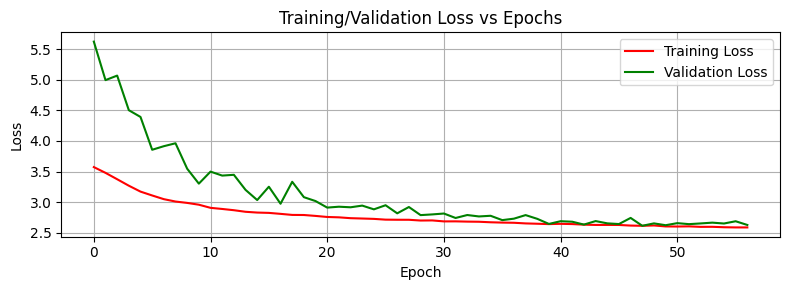


--- Running Final Test Examples ---
Loading best weights from models_pytorch/lipnet_checkpoint.pth for final test...
Best weights loaded successfully.

--- Example Predictions ---
Original:     place green with r seven again
Filtered Idx: [14]
Prediction:   n
--------------------------------------------------
Original:     bin green with u nine again
Filtered Idx: [14]
Prediction:   n
--------------------------------------------------
--- End Examples ---

--- Final Testing Finished ---


In [26]:
# --- Plotting Training/Validation Loss ---
plt.figure(figsize=(8, 3))
plt.plot(train_losses, color='red', label="Training Loss")
plt.plot(val_losses, color='green', label="Validation Loss")
plt.title("Training/Validation Loss vs Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve_pytorch.png")
plt.show()

print("\n--- Running Final Test Examples ---")
if os.path.exists(checkpoint_path):
    print(f"Loading best weights from {checkpoint_path} for final test...")
    try:
        checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Best weights loaded successfully.")
    except Exception as e:
        print(f"Error loading best weights: {e}")
else:
    print("No checkpoint found for final testing.")

produce_example(model, test_loader, num_to_char_dict) # Show examples with best model
print("--- Final Testing Finished ---")

# Testing on Unseen Speakers: s31, s32, s33

In [16]:
import random
def get_align_path(npy_path):
    parts = npy_path.split(os.path.sep)
    npy_filename = parts[-1]
    speaker_processed_dir = parts[-2] 
    base_name = os.path.splitext(npy_filename)[0]
    if base_name.endswith('_mouth'):
         base_name = base_name[:-6] 
    align_dir = os.path.join("./GRIDCorpus/data", speaker_processed_dir, 'align')
    return os.path.join(align_dir, f'{base_name}.align')
def load_alignments(align_file: str) -> Optional[List[str]]:
    alignments_chars = []
    try:
        with open(align_file, 'r') as f:
            for line in f:
                parts = line.strip().split();
                if len(parts) != 3: continue
                _, _, token = parts
                if token != 'sil': alignments_chars.extend(list(token.lower() + ' '))
        return alignments_chars[:-1] if alignments_chars else []
    except FileNotFoundError: return None
    except Exception as e: print(f"Error loading {align_file}: {e}"); return None
def load_and_normalize_npy(npy_path: str) -> Optional[torch.Tensor]:
    try:
        frames_uint8 = np.load(npy_path) 
        current_frame_count = frames_uint8.shape[0]
        if current_frame_count != FRAME_COUNT:
            if current_frame_count > FRAME_COUNT:
                frames_uint8 = frames_uint8[:FRAME_COUNT, ...]
            else:
                pad_width = ((0, FRAME_COUNT - current_frame_count), (0, 0), (0, 0), (0, 0))
                frames_uint8 = np.pad(frames_uint8, pad_width, mode='constant', constant_values=0)
        frames_float = frames_uint8.astype(np.float32) / 255.0
        frames_rgb = frames_float[..., ::-1]
        frames_normalized = (frames_rgb - NORM_MEAN) / NORM_STD
        frames_tensor = torch.tensor(frames_normalized, dtype=torch.float32)
        if frames_tensor.shape != (FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS):
            print(f"Warning: Final tensor shape is incorrect for {npy_path}: {frames_tensor.shape}")
            return None
        return frames_tensor 
    except FileNotFoundError:
        print(f"Warning: Npy file not found {npy_path}.")
        return None
    except Exception as e:
        print(f"Error loading/processing npy {npy_path}: {e}")
        return None
def greedy_decoder(log_probs, input_lengths):
    decoded_sequences = []
    for i in range(log_probs.size(1)):
        sample_log_probs = log_probs[:input_lengths[i], i, :]
        best_path = torch.argmax(sample_log_probs, dim=1)
        decoded = []
        last_char = -1
        for char_idx in best_path:
            idx = char_idx.item()
            if idx != last_char and idx != CTC_BLANK_INDEX:
                decoded.append(idx)
            if idx != CTC_BLANK_INDEX:
                last_char = idx
        decoded_sequences.append(decoded)
    return decoded_sequences
class LipNet(nn.Module):
    def __init__(self, num_classes, dropout_p=DROPOUT_P):
        super(LipNet, self).__init__()
        self.num_classes = num_classes 
        self.dropout_p = dropout_p
        self.conv1 = nn.Conv3d(FRAME_CHANNELS, 32, kernel_size=(3, 5, 5), stride=(1, 2, 2), padding=(1, 2, 2))
        self.bn1 = nn.BatchNorm3d(32)
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.drop1 = nn.Dropout3d(dropout_p)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 5, 5), stride=(1, 1, 1), padding=(1, 2, 2))
        self.bn2 = nn.BatchNorm3d(64)
        self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.drop2 = nn.Dropout3d(dropout_p)
        self.conv3 = nn.Conv3d(64, 96, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.bn3 = nn.BatchNorm3d(96)
        self.pool3 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.drop3 = nn.Dropout3d(dropout_p)
        self.rnn_input_size = 96 * 3 * 6
        self.gru1 = nn.GRU(self.rnn_input_size, 256, bidirectional=True, batch_first=True)
        self.drop_gru1 = nn.Dropout(dropout_p)
        self.gru2 = nn.GRU(256 * 2, 256, bidirectional=True, batch_first=True)
        self.drop_gru2 = nn.Dropout(dropout_p)
        self.fc = nn.Linear(256 * 2, self.num_classes)
    def forward(self, x):
        x = x.permute(0, 4, 1, 2, 3).contiguous()
        x = self.conv1(x); x = self.bn1(x); x = F.relu(x); x = self.pool1(x); x = self.drop1(x)
        x = self.conv2(x); x = self.bn2(x); x = F.relu(x); x = self.pool2(x); x = self.drop2(x)
        x = self.conv3(x); x = self.bn3(x); x = F.relu(x); x = self.pool3(x); x = self.drop3(x)
        N, C, T, H, W = x.size(); x = x.permute(0, 2, 1, 3, 4).contiguous(); x = x.view(N, T, -1)
        x, _ = self.gru1(x); x = self.drop_gru1(x)
        x, _ = self.gru2(x); x = self.drop_gru2(x)
        x = self.fc(x)
        x = x.permute(1, 0, 2).contiguous()
        log_probs = F.log_softmax(x, dim=2)
        return log_probs
K = 20 
CHECKPOINT_PATH = './models_pytorch/lipnet_checkpoint.pth' 
ALL_SPEAKER_IDS_NUM = ["s31_processed", "s32_processed", "s33_processed"]
print("Loading trained model...")
model = LipNet(num_classes=VOCAB_SIZE + 1).to(DEVICE)
if not os.path.exists(CHECKPOINT_PATH):
    print(f"Error: Checkpoint file not found at {CHECKPOINT_PATH}")
    exit()
try:
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval() 
    print(f"Model loaded successfully from epoch {checkpoint.get('epoch', 'N/A')}")
except Exception as e:
    print(f"Error loading model state_dict: {e}")
    exit()
print("\nFinding all processed .npy files...")
all_npy_files = []
for speaker_id_num in ALL_SPEAKER_IDS_NUM:
    speaker_processed_folder = f"{speaker_id_num}"
    speaker_path_pattern = os.path.join(BASE_PROCESSED_PATH, speaker_processed_folder, '*.npy')
    files = glob.glob(speaker_path_pattern)
    if not files:
        print(f"Warning: No .npy files found for speaker {speaker_id_num} in {os.path.join(BASE_PROCESSED_PATH, speaker_processed_folder)}")
    all_npy_files.extend(files)
if not all_npy_files:
    print(f"Error: No .npy files found in subdirectories like {os.path.join(BASE_PROCESSED_PATH, 's*_processed/')}. Ensure preprocessing was done and BASE_PROCESSED_PATH is correct.")
    exit()
print(f"Found {len(all_npy_files)} total .npy files.")
random.shuffle(all_npy_files)
selected_files = all_npy_files[:K]
print(f"\nSelected {len(selected_files)} files for testing.")
print("\n--- Running Inference on Selected Samples ---")
correct_predictions = 0
processed_count = 0
with torch.no_grad():
    for i, npy_path in enumerate(selected_files):
        print(f"\n--- Sample {i+1}/{K} ---")
        print(f"File: {npy_path}")
        frames_tensor = load_and_normalize_npy(npy_path)
        if frames_tensor is None:
            print("  Skipping due to loading/preprocessing error.")
            continue
        input_batch = frames_tensor.unsqueeze(0).to(DEVICE) 
        align_path = get_align_path(npy_path)
        alignments_list = load_alignments(align_path)
        if alignments_list is None:
            print(f"  Skipping due to missing alignment file: {align_path}")
            continue
        original_text = "".join(alignments_list)
        print(f"Original:     {original_text}")
        log_probs = model(input_batch) 
        input_lengths = torch.tensor([FRAME_COUNT], dtype=torch.long).cpu()
        decoded_indices_list = greedy_decoder(log_probs.cpu(), input_lengths)
        prediction_indices = decoded_indices_list[0]
        prediction_text = "".join([num_to_char_dict.get(idx, '?') for idx in prediction_indices])
        print(f"Prediction:   {prediction_text}")
        processed_count += 1
        if original_text == prediction_text:
             correct_predictions += 1
print("\n--- Testing Summary ---")
if processed_count > 0:
    accuracy = (correct_predictions / processed_count) * 100
    print(f"Successfully processed: {processed_count}/{len(selected_files)}")
    print(f"Correct Predictions: {correct_predictions}/{processed_count}")
    print(f"Accuracy on processed samples: {accuracy:.2f}%")
else:
    print("No samples were successfully processed for testing.")

Loading trained model...
Model loaded successfully from epoch 285

Finding all processed .npy files...
Found 3000 total .npy files.

Selected 20 files for testing.

--- Running Inference on Selected Samples ---

--- Sample 1/20 ---
File: ./GRIDCorpus/processed_mouth_data/s33_processed/srwz2n_mouth.npy
Original:     set red with z sp two now
Prediction:   sat breit ie naon

--- Sample 2/20 ---
File: ./GRIDCorpus/processed_mouth_data/s32_processed/srbe7n_mouth.npy
Original:     set red by e seven now
Prediction:   say wreit ie naon

--- Sample 3/20 ---
File: ./GRIDCorpus/processed_mouth_data/s31_processed/prif8p_mouth.npy
Original:     place red in f eight please
Prediction:   sate breit ie eaon

--- Sample 4/20 ---
File: ./GRIDCorpus/processed_mouth_data/s32_processed/sriq8s_mouth.npy
Original:     set red in q eight soon
Prediction:   say greit ie naon

--- Sample 5/20 ---
File: ./GRIDCorpus/processed_mouth_data/s32_processed/pwaa4a_mouth.npy
Original:     place white at a four again
P